Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
 5   species            150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None 

Class Distribution:

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64 



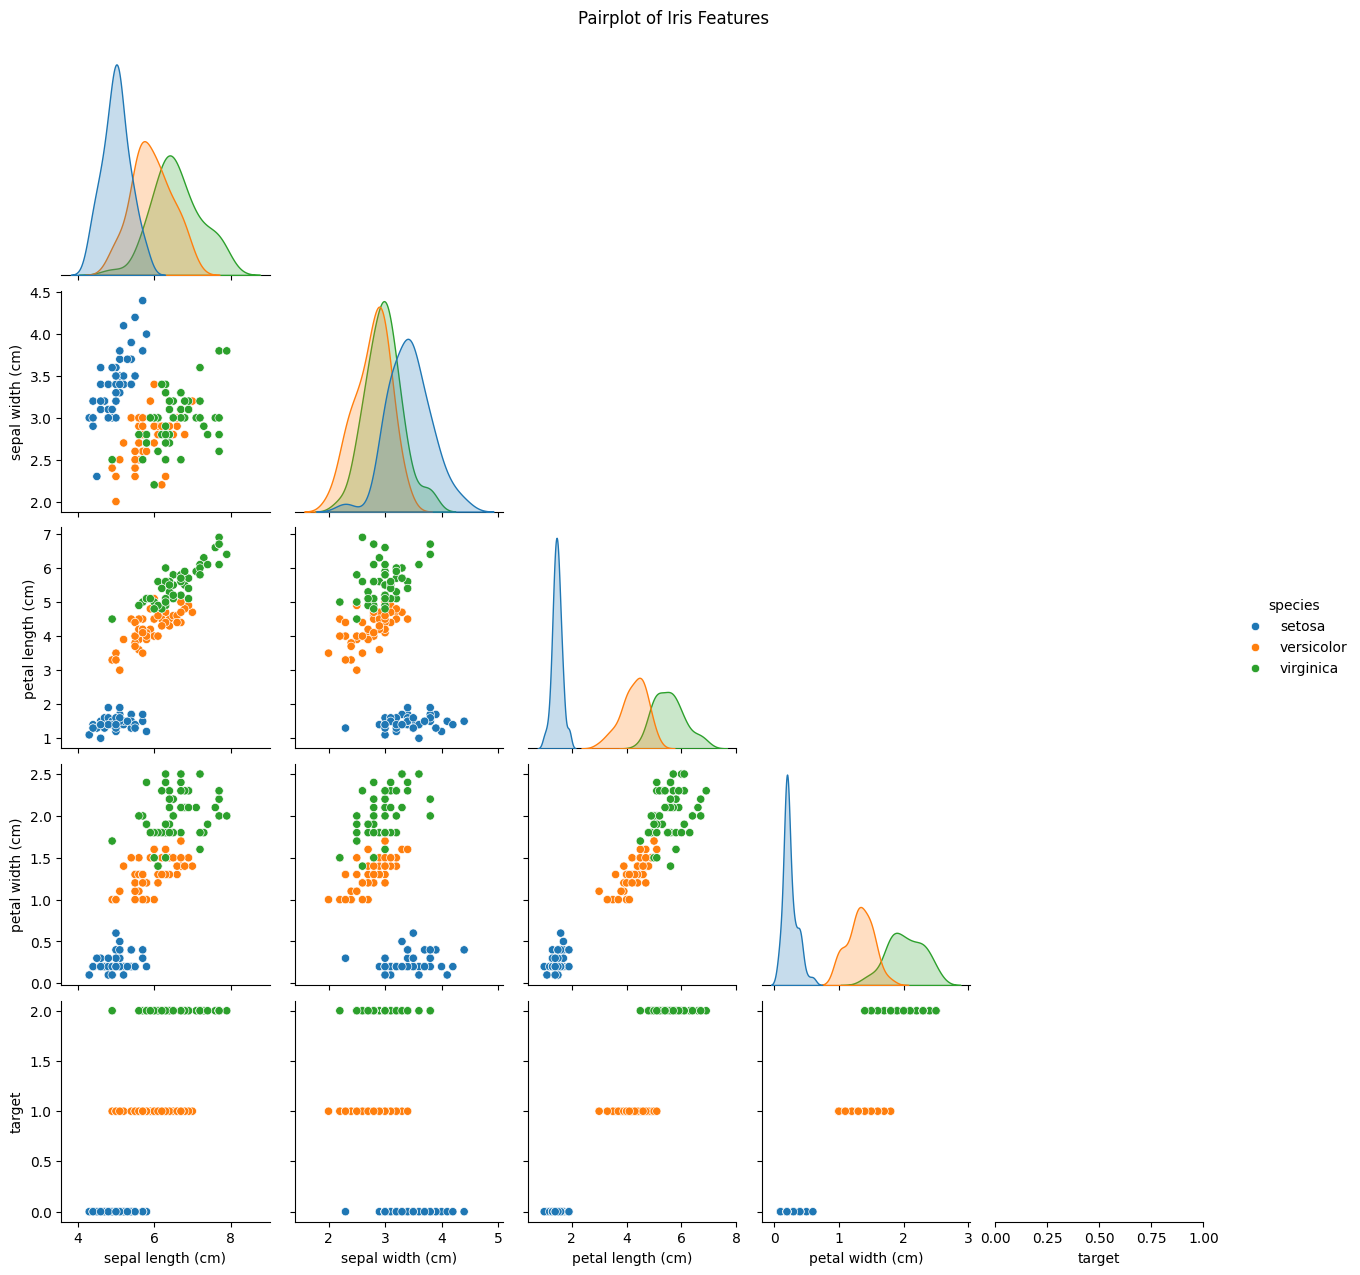

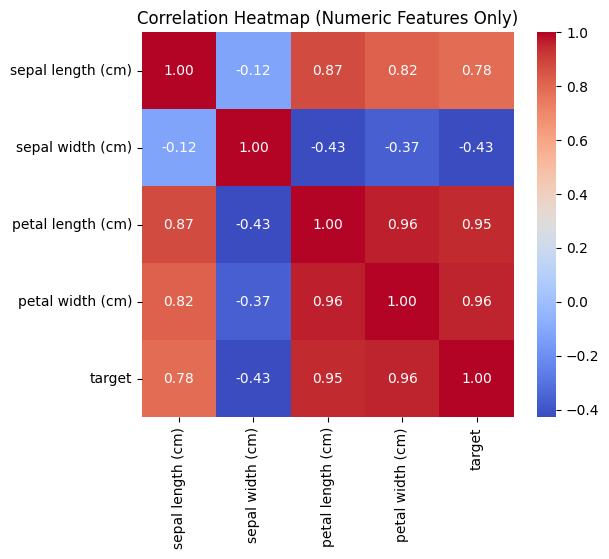

Engineered Features Preview:
    sepal_area  petal_area  sepal_petal_ratio
0       17.85        0.28           3.642857
1       14.70        0.28           3.500000
2       15.04        0.26           3.615385
3       14.26        0.30           3.066667
4       18.00        0.28           3.571429 


Logistic Regression Accuracy: 0.967
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



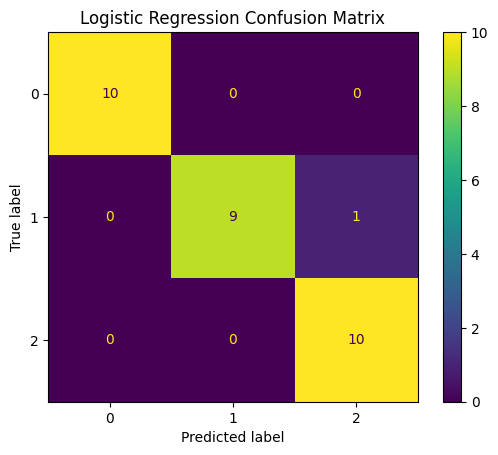


Decision Tree Accuracy: 0.900
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.89      0.80      0.84        10
           2       0.82      0.90      0.86        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



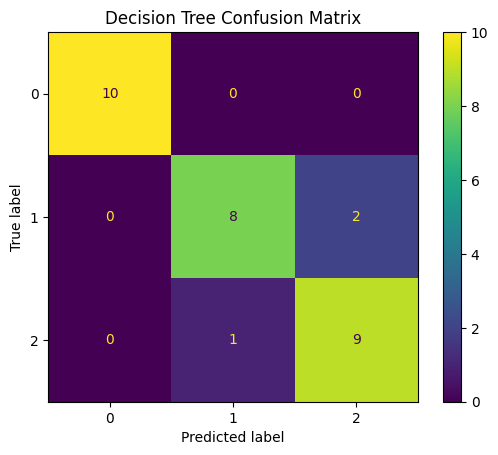


Random Forest (tuned) Accuracy: 0.967
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



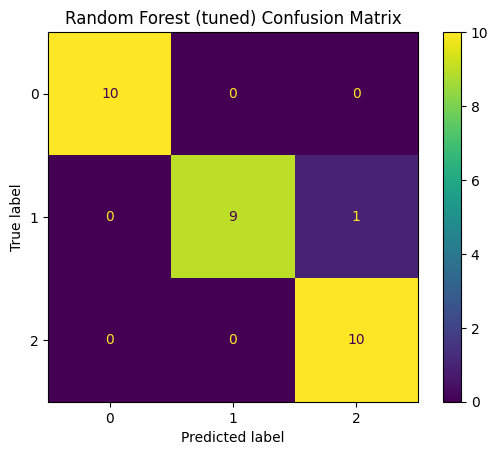

Saved model1.pkl, model2.pkl, model3.pkl in the app/ directory.


In [6]:
# =============================================================================
# 1. Libraries & Data Loading
# =============================================================================
import os, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

%matplotlib inline

# Load Iris into DataFrame
iris = load_iris(as_frame=True)
df = iris.frame
df['species'] = iris.target_names[df['target']]

# =============================================================================
# 2. Exploratory Data Analysis (EDA) — FIXED
# =============================================================================

print("Data Info:\n")
print(df.info(), "\n")

print("Class Distribution:\n")
print(df['species'].value_counts(), "\n")

# Pairplot (categorical hue)
sns.pairplot(df, hue='species', corner=True)
plt.suptitle("Pairplot of Iris Features", y=1.02)
plt.show()

# Correlation heatmap on **numeric** columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(6,5))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

# =============================================================================
# 3. Feature Engineering
# =============================================================================
df['sepal_area'] = df['sepal length (cm)'] * df['sepal width (cm)']
df['petal_area'] = df['petal length (cm)'] * df['petal width (cm)']
df['sepal_petal_ratio'] = df['sepal length (cm)'] / df['petal length (cm)']

print("Engineered Features Preview:\n",
      df[['sepal_area','petal_area','sepal_petal_ratio']].head(), "\n")

# =============================================================================
# 4. Prepare Data for Modeling
# =============================================================================
feature_cols = [
    'sepal length (cm)', 'sepal width (cm)',
    'petal length (cm)', 'petal width (cm)',
    'sepal_area', 'petal_area', 'sepal_petal_ratio'
]
X = df[feature_cols]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =============================================================================
# 5. Preprocessing & Pipeline Setup
# =============================================================================
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), feature_cols)
])

pipeline_lr = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
pipeline_dt = Pipeline([
    ('prep', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])
pipeline_rf = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

# =============================================================================
# 6. Train & Evaluate
# =============================================================================
pipeline_lr.fit(X_train, y_train)
pipeline_dt.fit(X_train, y_train)

# Hyperparameter tuning for RF
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 3, 5, 7],
    'clf__min_samples_split': [2, 5, 10]
}
grid = GridSearchCV(pipeline_rf, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
best_rf = grid.best_estimator_

# Test evaluation
for name, model in [
    ('Logistic Regression', pipeline_lr),
    ('Decision Tree', pipeline_dt),
    ('Random Forest (tuned)', best_rf)
]:
    preds = model.predict(X_test)
    print(f"\n{name} Accuracy: {accuracy_score(y_test, preds):.3f}")
    print(classification_report(y_test, preds))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

# =============================================================================
# 7. Save Models
# =============================================================================

with open('../app/model1.pkl', 'wb') as f: pickle.dump(pipeline_lr, f)
with open('../app/model2.pkl', 'wb') as f: pickle.dump(pipeline_dt, f)
with open('../app/model3.pkl', 'wb') as f: pickle.dump(best_rf, f)

print("Saved model1.pkl, model2.pkl, model3.pkl in the app/ directory.")
